# Bacillus subtilis reconstruction

To construct a metabolic model for Bacillus subtilis, we first import the MetaCyc database into moped from its PGDB files.

In [1]:
import pkg_resources
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from moped import Reaction, Model
from moped.utils import blast_is_installed
from cobra.flux_analysis import pfba
print(pkg_resources.get_distribution("moped").version)

1.9.0


In [2]:
metacyc = Model()
metacyc.read_from_pgdb(pgdb_path=Path("..") / "data" / "metacyc" / "25.1" / "data")
metacyc


Model: Model
    compounds: 12840
    reactions: 18393

## Create model from proteome/genome or database

If we have BLAST installed, we can use the functions `create_submodel_from_proteome` or `create_submodel_from_genome` to import a proteome/genome fasta file and BLAST it against the MetaCyc database to construct a model of all reactions that can be found in the genome sequence.

Alternatively, its possible to import the BioCyc PGDB files of B. subtilis using `read_from_pgdb` and `update_from_reference` to avoid version discrepancies.

In [3]:
if not blast_is_installed():
    raise OSError("Could not find blast. Please make sure its on your path.")

fastacyc = metacyc.create_submodel_from_proteome(
    "../data/proteomes/bacillus.fasta",
    name="bacillus",
    cache_blast_results=True,
    max_evalue=1e-03,
    min_coverage=40,
    min_pident=40,
)
fastacyc


Model: bacillus
    compounds: 1388
    reactions: 1183

## Topological gapfilling

In order to apply topological gapfilling to enable our model to produce biomass compounds, we apply cofactor and reversibility duplication for both draft and reference objects (see manuscript).

After getting a the template biomass compounds using `get_biomass_template`, we define a minimal medium seed including weak mock cofactors.

The function `get_gapfilling_reactions` uses Meneco gapfilling to find a minimal set of missing reactions from the reference moped object to produce all targets, and returns the list of reaction IDs in a list.
A result of previous gapfilling is provided, but can be commented out for new calculations.

These reactions are then added to the draft moped object from the reference moped object.

In [4]:
medium = [
    "ALPHA-GLUCOSE_c",
    "WATER_c",
    "PROTON_c",
    "OXYGEN-MOLECULE_c",
    "Pi_c",
    "SULFATE_c",
    "AMMONIA_c",
] 

seed = medium + metacyc.get_weak_cofactor_duplications()

biomass_comp = fastacyc.get_biomass_template()

# Manual additions to be always sure they are there
for rxn in list(metacyc.pathways["GLYCOLYSIS"]):
    if rxn not in list(fastacyc.reactions):
        fastacyc.add_reaction_from_reference(metacyc, rxn)

for rxn in list(metacyc.pathways["TCA"]):
    if rxn not in list(fastacyc.reactions):
        fastacyc.add_reaction_from_reference(metacyc, rxn)

In [5]:
metacyc.cofactor_duplication()
metacyc.reversibility_duplication()
fastacyc.cofactor_duplication()
fastacyc.reversibility_duplication()

In [6]:
# Topological gapfilling can take quite a while, so we cached the results here
gapfill_result = [
    "PLASTOQUINOL--PLASTOCYANIN-REDUCTASE-RXN__var__0_c_p__cof__",
    "RXN0-5224_c__rev__",
    "RXN0-742_c__cof__",
    "ATPSYN-RXN_c_p__cof____rev__",
    "RXN0-1401_c__cof__",
    "RXN-12303__var__0_c__cof__",
    "RXN0-5114_c",
    "RXN-20084_c__cof__",
    "RXN0-1402_c__cof__",
    "PYRUVDEH-RXN_c__cof__",
]
if gapfill_result is None:
    gapfill_result = fastacyc.get_gapfilling_reactions(
        reference_model=metacyc,
        seed=seed,
        targets=["UTP_c", "ATP_c", "GTP_c", "CTP_c"],
        verbose=True,
    )
for reaction_id in gapfill_result:
    fastacyc.add_reaction_from_reference(reference_model=metacyc, reaction_id=reaction_id)


In [7]:
# Topological gapfilling can take quite a while, so we cached the results here
gapfill_result = [
    "PRIBFAICARPISOM-RXN_c",
    "TYROSINE-AMINOTRANSFERASE-RXN_c__rev__",
    "NADH-KINASE-RXN_c",
    "RXN-18377_c",
    "RXN-8001_c__cof__",
    "HOMOSERKIN-RXN_c__cof__",
    "6.3.1.4-RXN_c",
    "NICONUCADENYLYLTRAN-RXN_c",
    "ADENYLYLSULFATE-REDUCTASE-RXN_c__cof____rev__",
    "DIHYDROFOLATESYNTH-RXN_c__cof__",
    "PRAISOM-RXN_c",
    "RXN0-7066_c",
    "PRTRANS-RXN_c__rev__",
    "ATPPHOSPHORIBOSYLTRANS-RXN_c__rev__",
    "ASPDECARBOX-RXN_c",
    "HOMOCYSMETB12-RXN__var__1_c",
    "GLUTAMIDOTRANS-RXN_c",
    "PREPHENATE-DEHYDROGENASE-NADP+-RXN_c",
    "ORNITHINE-CYCLODEAMINASE-RXN_c",
    "QUINOLINATE-SYNTHE-MULTI-RXN_c",
    "TRYPSYN-RXN_c",
    "CHORISMATE-SYNTHASE-RXN_c",
    "RXN-11334__var__1_c__cof__",
    "2-DEHYDROPANTOATE-REDUCT-RXN_c",
    "HISTAMINOTRANS-RXN_c__rev__",
    "1.5.1.20-RXN__var__2_c__cof____rev__",
    "HOMOSERDEHYDROG-RXN__var__0_c",
    "RXN-7737_c__rev__",
    "GLUTKIN-RXN_c",
]
if gapfill_result is None:
    gapfill_result = fastacyc.get_gapfilling_reactions(
        reference_model=metacyc,
        seed=seed,
        targets=biomass_comp,
        verbose=True,
    )
for reaction_id in gapfill_result:
    fastacyc.add_reaction_from_reference(reference_model=metacyc, reaction_id=reaction_id)


In [8]:
# Remove duplications
fastacyc.remove_cofactor_duplication()
fastacyc.remove_reversibility_duplication()
metacyc.remove_cofactor_duplication()
metacyc.remove_reversibility_duplication()

## Flux Balance Analysis (FBA)

To test our model using FBA later, we define a biomass reaction, which is a simplified version of the E. coli iJO1366 reaction, and an ATPase reaction as an atp maintenance requirement, and add both to the draft moped object.

Sometimes not all Biomass compounds are included in draft moped objects. To avoid problems, we also add any missing compounds from to the draft object from the reference object.

In [9]:
atpase_rxn = Reaction(
    id="ATPase",
    stoichiometries={"ATP_c": -1, "WATER_c": -1, "ADP_c": 1, "Pi_c": 1, "PROTON_c": 1},
    bounds=(0.0, 1000.0),
)
biomass_rxn = Reaction(
    id="BIOMASS",
    stoichiometries=biomass_comp,
    bounds=(0.0, 1000.0),
)

excluded = set(medium + ["CARBON-DIOXIDE_c"])
cytosol = set(fastacyc.get_compounds_of_compartment("CYTOSOL")).difference(excluded)

for compound_id in biomass_comp:
    if compound_id not in fastacyc.compounds:
        fastacyc.add_compound_from_reference(reference_model=metacyc, compound_id=compound_id)

for compound_id in excluded:
    fastacyc.add_transport_reaction(compound_id=compound_id, compartment_id="EXTRACELLULAR")
    fastacyc.add_medium_component(compound_id=compound_id, extracellular_compartment_id="EXTRACELLULAR")


fastacyc.add_reaction(biomass_rxn)
fastacyc.add_reaction(atpase_rxn)

fastacyc.reactions["EX_ALPHA-GLUCOSE_e"].bounds = (-10, 10)
fastacyc.objective = {"BIOMASS": 1}


In order to apply Flux Balance Analysis to our model, we add exchange reactions that can introduce compounds into our model for all medium seed compounds using `add_transport_reaction` and `add_medium_component`.  
In this model, we allow Carbon Dioxide to leave the model via a respective efflux reaction.
We define a new variable in which we export our moped object into a CobraPy object, and set the objective coefficient of our Biomass reaction to 1.

In [10]:
all_exporters = fastacyc.copy()

for compound_id in cytosol:
    all_exporters.add_transport_reaction(compound_id, "EXTRACELLULAR")
    all_exporters.add_efflux(compound_id, "EXTRACELLULAR")

m_ex = all_exporters.to_cobra()

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


In [11]:
df = pfba(m_ex).to_frame()
ex = df[df.index.str.startswith("EX")]
exporters = ex[ex["fluxes"].abs() > 1e-3]
exporters

fluxes  reduced_costs
EX_Pi_e               -3.758297            2.0
EX_ALPHA-GLUCOSE_e   -10.000000           48.0
EX_OXYGEN-MOLECULE_e -13.029337            2.0
EX_AMMONIA_e          -7.074382            2.0
EX_PROTON_e            7.982044           -2.0
EX_SULFATE_e          -0.274613            2.0
EX_WATER_e            31.472503           -2.0
EX_CARBON-DIOXIDE_e   12.837641           -2.0
EX_FORMALDEHYDE_e      0.146767           -2.0
EX_ACET_e             12.335861           -2.0
EX_CPD-15403_e         0.118083           -2.0
EX_PPI_e               1.237324           -2.0

In [12]:
new_to_export = {cpd for i in exporters.index if (cpd := f"{i[3:-2]}_c") not in excluded}

for compound_id in new_to_export:
    fastacyc.add_transport_reaction(compound_id=compound_id, compartment_id="EXTRACELLULAR")
    fastacyc.add_medium_component(compound_id=compound_id, extracellular_compartment_id="EXTRACELLULAR")
new_to_export

{'ACET_c', 'CPD-15403_c', 'FORMALDEHYDE_c', 'PPI_c'}

In [13]:
m_fc = fastacyc.to_cobra()
m_fc.optimize()["BIOMASS"]

0.655940530332511

## ATP maintenance scan

Good indicator for thermodynamically infeasible loops

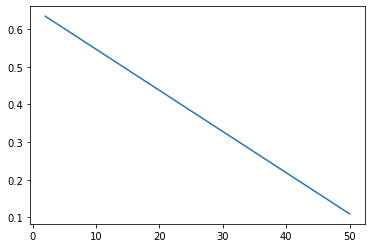

In [14]:
atp = np.linspace(2, 50, 10)
biomass = []
for i in atp:
    m_fc.reactions.get_by_id("ATPase").bounds = (i, 1000)
    biomass.append(pfba(m_fc).to_frame()["fluxes"]["BIOMASS"])

fig, ax = plt.subplots()
ax.plot(atp, biomass)
plt.show()


## SBML export

To export a model SBML including all desired annotations we use the `to_sbml` function to create a sbml model which can be re-used and tested using MEMOTE.

In [15]:
fastacyc.to_sbml(Path("..") / "generated" / "models" / "bacillus.xml")
